<a href="https://colab.research.google.com/github/juanhdez360/av-fantastico/blob/main/Avance1_Equipo33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

**Tecnológico de Monterrey**

Profesores:
Dr. Luis Eduardo Falcón Morales, Dra. Grettel Barceló Alonso

**Avance 1. Análisis Exploratorio de Datos**

Algoritmo de Comportamiento para Vehículos Autónomos con Capacidad de Razonamiento

**Equipo 33**

A00464759	Luis Eduardo Calvillo Corona

A00889358	Sihiní Trinidad Sánchez

A01785878	Juan Manuel Hernández Carrillo

**Fecha: Enero 2026**



# **Análisis Exploratorio de Datos (EDA)**

# Objetivo
Explorar y comprender la estructura, calidad y relaciones de los datos generados por el carro guiado por el Fantástico,
para identificar patrones relevantes, problemas de calidad y decisiones de preprocesamiento
que impactarán las siguientes fases del proyecto. En esta libreta estaremos:
- Entendiendo estructura y calidad de los datos (faltantes, outliers, frecuencia).
- Analizando señales por `topic` (porque cada CSV trae varias señales).
- Prepararando el terreno para integración por tiempo (`t_ns`) y EDA multivariado.

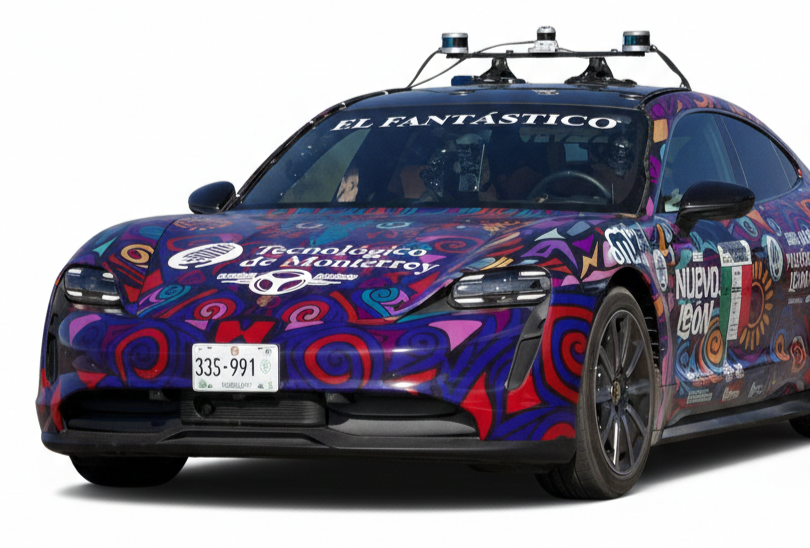

# I. Introducción



El equipo de Bloom Drive Intelligence nos proporcionó acceso a una muestra de datos recopilados por el Maserati GranCabrio Folgore de PoliMi que iba detrás del vehículo guía "Fantástico" del Tec de Monterrey en la Carrera Panamericana. La información representó más de 38GB correspondientes a aproximadamente 4.5 minutos de video y 800m de trayecto un tramo del segmento del recorrido en Puebla.  

Los datos se entregaron en un archivo de extensión “.mcap”, (abreviatura de Message Capture), el cual es un formato de archivo contenedor estandarizado y de código abierto creado por Foxglove para grabaciones de datos en robótica y sistemas autónomos. Este tipo de archivo está estructurado por tiempo donde cada mensaje guardado tiene una marca temporal (timestamp) precisa (nanosegundos), lo que permite reproducir la grabación exactamente como ocurrió en la vida real para poder analizar los datos de manera precisa.

Si bien esta extensión resuelve algunas limitaciones de formatos previos, es necesario un visualizador que pueda leer esta información, por lo que decidimos usar el propio software de Foxglove. El Tec de Monterrey tiene una cuenta gratuita como organización con las funciones básicas necesarias para realizar algunas visualizaciones de los datos.

A partir de ello, pudimos visualizar la información recopilada por los sensores, radares, y cámaras del Maserati y empezamos la selección de datos relevantes para bajarlos en formato .csv y hacer su procesamiento correspondiente. Cabe mencionar que los datos que recibimos se encuentran prácticamente completos, pero aún en .csv son de tipo logs ROS-style: elapsed time | timestamp | topic | value. Esto implica algo clave: el EDA no se hace “por archivo”, sino por “topic” (cada CSV contiene múltiples señales mezcladas, diferenciadas por la columna topic).

Contando con algunos días adicionales para complementar nuestra "pre-entrega" del 01 de febrero de 2025, pudimos realizar una mejor exploración inicial de los datos que complementa aquella explorada con el visualizador de Foxglove. En esta entrega se seleccionaron algunas variables clave de algunos sensores que en base a la exploración inicial se consideran como las señales de mayor valor para el propósito del proyecto integrador. Dada la riqueza y cantidad de la información y la labor de organizarla y transformarla de su versión cruda a una que sea útil un marco de analítica de datos, esta lista seguriá actualizándose conforme lo vaya requiriendo el proyecto.


# II. Carga de librerías y datos



In [ ]:
# Carga de directorio local en la nube
from google.colab import drive
drive.mount('/content/drive')
import os
DIR = "/content/drive/MyDrive/Proyecto Integrador Fantástico Navegación Autónoma/Datos CSV"
os.chdir(DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carga de librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# III. Información de los archivos a procesar

## Resumen de clasificación y datos disponible

La siguiente tabla resume la clasificación y cantidad de datos disponibles, la frecuencia con la que se recibieron y la fuente durante el periodo de duración del video. Asimismo, se proporciona una breve explicación de la función práctica que representan. Cabe mencionar que las variables, señales y tópicos vienen originalmente nombrados y abreviados en inglés por lo que a lo largo de este trabajo se hizo la labor de dar una trducción y explicación breve solamente la primera vez que se usan.

In [ ]:
#Cargar cuadro resumen generado anteriormente
tabla_resumen = pd.read_excel("Exploración de datos info.xlsx")

# Mostrar la tabla tal cual está en el Excel
tabla_resumen

,Topic Name,Datatype,Message count,Frecuencia,Descripción
0,/autopilot_fbk,move_common_msgs/msg/StampedUInt8,29238,108.21 Hz,Retroalimentación del Estado del Piloto Automá...
1,NaN,NaN,NaN,NaN,La frecuencia de transmisión es alta para aseg...
2,/ces_ars430di/sensor_30/detections/far,ros2_ars430di_driver/msg/RDIDetections,3376,12.50 Hz,4 radares Continental ARS430 (sensores 30 a 33).
3,/ces_ars430di/sensor_30/detections/near,ros2_ars430di_driver/msg/RDIDetections,3372,12.48 Hz,El hardware emite ondas de radio y mide el reb...
4,/ces_ars430di/sensor_30/objects_list,ros2_ars430di_driver/msg/RDIObjectsList,3431,12.70 Hz,El driver convierte esas señales en una lista ...
...,...,...,...,...,...
63,/speedgoat_fbk,move_common_msgs/msg/SpeedgoatFbk,29168,107.96 Hz,"Ejecuta la seguridad crítica (frenos, direcció..."
64,/tf,tf2_msgs/msg/TFMessage,42851,158.60 Hz,Transform Frames. Le dice al sistema cómo se m...
65,/tf_static,tf2_msgs/msg/TFMessage,3,0.01 Hz,Define las partes fijas que nunca cambian.
66,/to_can_bus/can1,can_msgs/msg/Frame,29159,107.92 Hz,Las desiciones del software se vuelven en mens...


## Tamaño e información de archivos CSV de datos seleccionados

Para el análisis EDA inicial se seleccionaron algunos topics representativos por cada tipo de sensor, priorizando variables continuas con significado físico directo en el comportamiento del vehículo. Se enfoco en variables de control, dinámica y estado estimaado para cubrir diferentes fuentes y evitar redundancia en el análisis.

In [ ]:
# Carga de datos de archivos .csv del directorio de trabajo
df_remote = pd.read_csv("remote_commands.csv")
df_fbk    = pd.read_csv("vehicle_fbk.csv")
df_latacc = pd.read_csv("vehicle_dyn_lat_acc.csv")
df_imu    = pd.read_csv("imu_data.csv")
df_velong = pd.read_csv("vehicle_dynamics_radio_vel_long.csv")
df_gps    = pd.read_csv("nav_sat_fix.csv")
df_ekftemp = pd.read_csv("ekf_temp.csv")
df_leaderdistance = pd.read_csv("leader_distance.csv")


#Verifica tamaños de cada archivo
print("\nTamaño de datos")
print("remote :", df_remote.shape)
print("fbk    :", df_fbk.shape)
print("latacc :", df_latacc.shape)
print("imu    :", df_imu.shape)
print("velong :", df_velong.shape)
print("gps    :", df_gps.shape)
print("efktemp :", df_ekftemp.shape)
print("leaderdistance :", df_leaderdistance.shape)

#Verifica tipo de datos de cada archivo
print("\nTipos de datos")

print("\nConducción autónoma remote_commands")
df_remote.info()

print("\n Feedback estado interno del vehículo vehicle_fbk")
df_fbk.info()

print("\nDirección angular, yaw rate vehicle_dyn_lat_acc")
df_latacc.info()

print("\nDinámica velocidad angulzar xyz imu_data")
df_imu.info()

print("\nVelocidad longitudinal vehicle_dynamics_radio_vel_long")
df_velong.info()

print("\nGPS nav_sat_fix")
df_gps.info()

print("\nEstado fusionado de sensores y transformaciones efk_temp")
df_gps.info()

print("\nDistancia al vehículo líder leader_distance")
df_leaderdistance.info()




Tamaño de datos
remote : (18, 4)
fbk    : (262341, 4)
latacc : (138775, 4)
imu    : (59763, 4)
velong : (55510, 4)
gps    : (15246, 5)
efktemp : (276989, 4)
leaderdistance : (142654, 4)

Tipos de datos

Conducción autónoma remote_commands
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   elapsed time  18 non-null     float64
 1   timestamp     18 non-null     float64
 2   topic         18 non-null     object 
 3   value         18 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 708.0+ bytes

 Feedback estado interno del vehículo vehicle_fbk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262341 entries, 0 to 262340
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   elapsed time  262341 non-null  float64
 1   timestamp     262341 non-null  floa

### **Resultados**

La mayoría de los archivos contienen variables categóricas (object) en la columna topic, que describe el tipo de medición, y variables numéricas (float64 o int64) que representan el valor de cada señal registrada.

* remote_commands: 18 registros de eventos discretos asociados al estado de conducción autónoma; se utiliza como variable de contexto.

* vehicle_fbk: 262,341 registros de feedback interno del vehículo; señal continua de alta frecuencia.

* vehicle_dyn_lat_acc: 138,775 registros de dinámica lateral (yaw rate / aceleración lateral); señal continua.

* imu_data: 59,763 registros de velocidad angular en los ejes del vehículo; señal continua con posible ruido de alta frecuencia.

* vehicle_dynamics_radio_vel_long: 55,510 registros de velocidad longitudinal; variable clave para el análisis dinámico.

* nav_sat_fix (GPS): 15,246 registros de posición geográfica (latitud, longitud, altitud) y estado; señal de menor frecuencia.

* ekf_temp: 15,246 registros del estado fusionado de sensores mediante EKF (Filtro de Kalman Extendido por sus siglas en inglés), que integra posición geográfica y un indicador de estado; señal de menor frecuencia utilizada como referencia *estimada* del estado del vehículo.

* leader_distance: 142654 registros de distancia entre el vehículo Maserati GranCabrio Folgore de PoliMi y el vehículo guía el "Fantástico" del Tec de Monterrey.


## Vista rápida de columnas y ejemplos de registro

In [ ]:
#Muestra columnas y primeros registros de cada archivo

print("\nColumnas y ejemplo: remote_commands")
print(df_remote.columns)
display(df_remote.head())

print("\nColumnas y ejemplo: vehicle_fbk")
print(df_fbk.columns)
display(df_fbk.head())

print("\nColumnas y ejemplo: vehicle_dyn_lat_acc")
print(df_latacc.columns)
display(df_latacc.head())

print("\nColumnas y ejemplo: imu_data")
print(df_imu.columns)
display(df_imu.head())

print("\nColumnas y ejemplo: vehicle_dynamics_radio_vel_long")
print(df_velong.columns)
display(df_velong.head())

print("\nColumnas y ejemplo: nav_sat_fix")
print(df_gps.columns)
display(df_gps.head())

print("\nColumnas y ejemplo: efk_temp")
print(df_ekftemp.columns)
display(df_ekftemp.head())

print("\nColumnas y ejemplo: leader_distance")
print(df_leaderdistance.columns)
display(df_leaderdistance.head())




Columnas y ejemplo: remote_commands
Index(['elapsed time', 'timestamp', 'topic', 'value'], dtype='object')


,elapsed time,timestamp,topic,value
0,21.790016,1.760117e+09,/remote_supervision/remote_commands.emerg_stop,0
1,216.107423,1.760117e+09,/remote_supervision/remote_commands.emerg_stop,0
2,21.790016,1.760117e+09,/remote_supervision/remote_commands.enable_aut...,1
3,216.107423,1.760117e+09,/remote_supervision/remote_commands.enable_aut...,0
4,21.790016,1.760117e+09,/remote_supervision/remote_commands.go_forced,0



Columnas y ejemplo: vehicle_fbk
Index(['elapsed time', 'timestamp', 'topic', 'value'], dtype='object')


,elapsed time,timestamp,topic,value
0,0.310063,1.760117e+09,/vehicle_fbk.throttle_position,6.272
1,0.327102,1.760117e+09,/vehicle_fbk.throttle_position,5.488
2,0.342822,1.760117e+09,/vehicle_fbk.throttle_position,5.488
3,0.349800,1.760117e+09,/vehicle_fbk.throttle_position,5.880
4,0.359484,1.760117e+09,/vehicle_fbk.throttle_position,5.880



Columnas y ejemplo: vehicle_dyn_lat_acc
Index(['elapsed time', 'timestamp', 'topic', 'value'], dtype='object')


,elapsed time,timestamp,topic,value
0,0.048878,1.760117e+09,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.171359
1,0.061621,1.760117e+09,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.171359
2,0.070091,1.760117e+09,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.165751
3,0.081128,1.760117e+09,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.152061
4,0.091687,1.760117e+09,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.138953



Columnas y ejemplo: imu_data
Index(['elapsed time', 'timestamp', 'topic', 'value'], dtype='object')


,elapsed time,timestamp,topic,value
0,0.036272,1.760117e+09,/imu/data.angular_velocity.x,-0.006910
1,0.048860,1.760117e+09,/imu/data.angular_velocity.x,-0.007545
2,0.061830,1.760117e+09,/imu/data.angular_velocity.x,-0.004796
3,0.071309,1.760117e+09,/imu/data.angular_velocity.x,-0.005608
4,0.090066,1.760117e+09,/imu/data.angular_velocity.x,-0.002331



Columnas y ejemplo: vehicle_dynamics_radio_vel_long
Index(['elapsed time', 'timestamp', 'topic', 'value'], dtype='object')


,elapsed time,timestamp,topic,value
0,0.048878,1.760117e+09,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.090861
1,0.061621,1.760117e+09,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.091252
2,0.070091,1.760117e+09,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.092033
3,0.081128,1.760117e+09,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.092641
4,0.091687,1.760117e+09,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.094043



Columnas y ejemplo: nav_sat_fix
Index(['t_ns', 'lat', 'lon', 'alt', 'status'], dtype='object')


,t_ns,lat,lon,alt,status
0,1760116966055282496,19.019505,-98.243699,2108.387842,1
1,1760116966065674008,19.019505,-98.243699,2108.386022,1
2,1760116966078651333,19.019505,-98.243698,2108.387034,1
3,1760116966088375013,19.019505,-98.243698,2108.385221,1
4,1760116966106885858,19.019505,-98.243698,2108.384219,1



Columnas y ejemplo: efk_temp
Index(['elapsed time', 'timestamp', 'topic', 'value'], dtype='object')


,elapsed time,timestamp,topic,value
0,0.327143,1.760117e+09,/estimation/ekf/gnss/vehicle_state.status,1.0
1,0.343679,1.760117e+09,/estimation/ekf/gnss/vehicle_state.status,1.0
2,0.352052,1.760117e+09,/estimation/ekf/gnss/vehicle_state.status,1.0
3,0.362261,1.760117e+09,/estimation/ekf/gnss/vehicle_state.status,1.0
4,0.376671,1.760117e+09,/estimation/ekf/gnss/vehicle_state.status,1.0



Columnas y ejemplo: leader_distance
Index(['elapsed time', 'timestamp', 'topic', 'value'], dtype='object')


,elapsed time,timestamp,topic,value
0,13.931237,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.352364
1,13.936586,1.760117e+09,/planning/leader_following/leader_distance.dis...,inf
2,13.938404,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.338982
3,13.947964,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.351946
4,13.957742,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.356758


# Inventario de *topics* (identificación de variables)

In [ ]:
#Identifica los topics disponibles en cada archivo

def resumen_topics(df, nombre):
    print("\n--------------------------------------------")
    print("Topics en:", nombre)
    print("Número de topics:", df["topic"].nunique())
    print("\nConteo de registros por topic:")
    display(df["topic"].value_counts())

resumen_topics(df_remote, "remote_commands")
resumen_topics(df_fbk,    "vehicle_fbk")
resumen_topics(df_latacc, "vehicle_dyn_lat_acc")
resumen_topics(df_imu,    "imu_data")
resumen_topics(df_velong, "vehicle_dynamics_radio_vel_long")
resumen_topics(df_ekftemp, "efk_temp")
resumen_topics(df_leaderdistance, "leader_distance")


--------------------------------------------
Topics en: remote_commands
Número de topics: 9

Conteo de registros por topic:


,count
topic,
/remote_supervision/remote_commands.emerg_stop,2
/remote_supervision/remote_commands.enable_autopilot,2
/remote_supervision/remote_commands.go_forced,2
/remote_supervision/remote_commands.go_soft,2
/remote_supervision/remote_commands.go_step,2
/remote_supervision/remote_commands.is_remote,2
/remote_supervision/remote_commands.path_select,2
/remote_supervision/remote_commands.safe_stop,2
/remote_supervision/remote_commands.stop,2



--------------------------------------------
Topics en: vehicle_fbk
Número de topics: 9

Conteo de registros por topic:


,count
topic,
/vehicle_fbk.throttle_position,29149
/vehicle_fbk.steering_wheel_angle,29149
/vehicle_fbk.yaw_rate,29149
/vehicle_fbk.voltage,29149
/vehicle_fbk.v_fl,29149
/vehicle_fbk.v_fr,29149
/vehicle_fbk.v_rl,29149
/vehicle_fbk.v_rr,29149
/vehicle_fbk.brake_pedal_position,29149



--------------------------------------------
Topics en: vehicle_dyn_lat_acc
Número de topics: 5

Conteo de registros por topic:


,count
topic,
/ces_ars430di/vehicle_dynamics.lateral_acceleration,27755
/ces_ars430di/vehicle_dynamics.longitudinal_acceleration,27755
/ces_ars430di/vehicle_dynamics.longitudinal_direction,27755
/ces_ars430di/vehicle_dynamics.longitudinal_velocity,27755
/ces_ars430di/vehicle_dynamics.yaw_rate,27755



--------------------------------------------
Topics en: imu_data
Número de topics: 3

Conteo de registros por topic:


,count
topic,
/imu/data.angular_velocity.x,19921
/imu/data.angular_velocity.y,19921
/imu/data.angular_velocity.z,19921



--------------------------------------------
Topics en: vehicle_dynamics_radio_vel_long
Número de topics: 2

Conteo de registros por topic:


,count
topic,
/ces_ars430di/vehicle_dynamics.longitudinal_velocity,27755
/ces_ars430di/vehicle_dynamics.lateral_acceleration,27755



--------------------------------------------
Topics en: efk_temp
Número de topics: 8

Conteo de registros por topic:


,count
topic,
/estimation/ekf/nav_sat_fix.position_covariance[:],137214
/imu/temp.temperature,20341
/estimation/ekf/vehicle_state.vy,19919
/estimation/ekf/vehicle_state.vx,19919
/estimation/ekf/gnss/vehicle_state.vy,19899
/estimation/ekf/gnss/vehicle_state.vx,19899
/estimation/ekf/gnss/vehicle_state.status,19899
/estimation/ekf/gnss/vehicle_state.yaw_rate,19899



--------------------------------------------
Topics en: leader_distance
Número de topics: 6

Conteo de registros por topic:


,count
topic,
/planning/leader_following/leader_distance.distance,24435
/planning/leader_following/leader_distance.speed,24435
/control/longitudinal/command.acc,23446
/control/longitudinal/command.emergency_brake,23446
/control/longitudinal/command.leader_speed_ref,23446
/control/longitudinal/command.v_max,23446


### **Resultados**

1. **remote_commands** (9 topics, 2 registros c/u): eventos discretos de control del sistema

* merg_stop: parada de emergencia

* enable_autopilot: habilitar/deshabilitar autopiloto

* go_forced: avance forzado

* go_soft: avance suave

* go_step: avance por pasos

* is_remote: indicador de control remoto activo

* path_select: selección de trayectoria/ruta

* safe_stop: parada segura

* stop: orden de parada


2. **vehicle_fbk** (9 topics, 29,149 registros c/u): feedback y estado del vehículo

* throttle_position: posición del acelerador

* brake_pedal_position: posición del freno

* steering_wheel_angle: ángulo del volante

* yaw_rate: tasa de giro (yaw rate)

* voltage: voltaje del sistema

* v_fl: velocidad rueda delantera izquierda

* v_fr: velocidad rueda delantera derecha

* v_rl: velocidad rueda trasera izquierda

* v_rr: velocidad rueda trasera derecha

3. **vehicle_dyn_lat_acc** (5 topics, 27,755 registros c/u): dinámica del vehículo

* lateral_acceleration: aceleración lateral

* longitudinal_acceleration: aceleración longitudinal

* longitudinal_direction: dirección longitudinal (sentido de avance)

* longitudinal_velocity: velocidad longitudinal

* yaw_rate: tasa de giro (yaw rate)

4. **imu_data** (3 topics, 19,921 registros c/u): IMU velocidad angular

* angular_velocity.x: rotación eje x

* angular_velocity.y: rotación eje y

* angular_velocity.z: rotación eje z

5. **vehicle_dynamics_radio_vel_long** (2 topics, 27,755 registros c/u): dinámica longitudinal/lateral

* longitudinal_velocity: velocidad longitudinal

* lateral_acceleration: aceleración lateral

6. **ekf_temp** (8 topics, ~19,900–137,214 registros): estado estimado del vehículo obtenido mediante fusión de sensores (EKF), que incluye:

* nav_sat_fix.position_covariance: incertidumbre de la posición GNSS estimada

* imu/temp.temperature: temperatura reportada por la IMU

* vehicle_state.vx: velocidad longitudinal estimada

* vehicle_state.vy: velocidad lateral estimada

* gnss/vehicle_state.vx: velocidad longitudinal estimada a partir de GNSS

* gnss/vehicle_state.vy: velocidad lateral estimada a partir de GNSS

* gnss/vehicle_state.yaw_rate: tasa de giro estimada a partir de GNSS

* gnss/vehicle_state.status: estado de validez de la estimación GNSS

7. **leader_distance** (6 topics): distancia del vehículo Maserati GranCabrio Folgore de PoliMi respecto al vehículo guía "Fantástico" del Tec de Monterrey. Hay dos categorías:
* Leader following [seguimiento de líder] (2 topics, 24,435 c/u) distancia al líder (distance) y velocidad del líder o relativa al líder (speed).
* Longitudinal control [control longitudinal] (4 topics, 23,446 c/u): aceleración (acc), frenado de emergencia (emergency_brake), velocidad de referencia del líder (leader_speed_ref), y velocidad máxima (v_max).


**Notas**:
* Los datos del GPS son coordenas y no vienen indexadas por *topic*.
* En leader_distance la ligera discrepancia en el número de registros entre las señales de planificación (leader following) y las señales de control longitudinal es consistente con arquitecturas ROS donde distintos nodos operan a frecuencias y ventanas temporales distintas.


# IV. Dataframes por topic

Identificar cada variable como una señal independiente permite realizar un análisis correcto y justifica técnicamente el EDA por topic y no por archivo.

## Justificación

En esta sección se exploran las variables de los sensores crudos. Las variables provenientes de ekf_temp corresponden a estados estimados mediante fusión de sensores, por lo que se incluyen en el análisis exploratorio únicamente con fines de validación y comparación, y no como señales primarias del comportamiento del vehículo.

In [ ]:
#Separa cada dataframe en sub-dataframes por topic

def separar_por_topic(df):
    dfs_por_topic = {}
    for t in df["topic"].unique():
        dfs_por_topic[t] = df[df["topic"] == t].copy()
    return dfs_por_topic


#Aplica separación por topic a cada archivo tipo ROS

remote_by_topic = separar_por_topic(df_remote)
fbk_by_topic    = separar_por_topic(df_fbk)
latacc_by_topic = separar_por_topic(df_latacc)
imu_by_topic    = separar_por_topic(df_imu)
velong_by_topic = separar_por_topic(df_velong)
ekftemp_by_topic = separar_por_topic(df_ekftemp)
leaderdistance_by_topic = separar_por_topic(df_leaderdistance)


#Verifica topics disponibles en cada diccionario

print("remote topics :", list(remote_by_topic.keys()))
print("fbk topics    :", list(fbk_by_topic.keys()))
print("latacc topics :", list(latacc_by_topic.keys()))
print("imu topics    :", list(imu_by_topic.keys()))
print("velong topics :", list(velong_by_topic.keys()))
print("ekftemp topics:", list(ekftemp_by_topic.keys()))
print("leaderdistance topics:", list(leaderdistance_by_topic.keys()))


remote topics : ['/remote_supervision/remote_commands.emerg_stop', '/remote_supervision/remote_commands.enable_autopilot', '/remote_supervision/remote_commands.go_forced', '/remote_supervision/remote_commands.go_soft', '/remote_supervision/remote_commands.go_step', '/remote_supervision/remote_commands.is_remote', '/remote_supervision/remote_commands.path_select', '/remote_supervision/remote_commands.safe_stop', '/remote_supervision/remote_commands.stop']
fbk topics    : ['/vehicle_fbk.throttle_position', '/vehicle_fbk.steering_wheel_angle', '/vehicle_fbk.yaw_rate', '/vehicle_fbk.voltage', '/vehicle_fbk.v_fl', '/vehicle_fbk.v_fr', '/vehicle_fbk.v_rl', '/vehicle_fbk.v_rr', '/vehicle_fbk.brake_pedal_position']
latacc topics : ['/ces_ars430di/vehicle_dynamics.lateral_acceleration', '/ces_ars430di/vehicle_dynamics.longitudinal_acceleration', '/ces_ars430di/vehicle_dynamics.longitudinal_direction', '/ces_ars430di/vehicle_dynamics.longitudinal_velocity', '/ces_ars430di/vehicle_dynamics.yaw_ra

## Selección de topics por sensor

A partir del inventario de topics y del análisis visual preliminar, se seleccionaron señales continuas con significado físico directo y variabilidad relevante durante el recorrido. Se buscó evitar redundancia entre variables que describen el mismo fenómeno y excluir señales discretas o auxiliares que no aportan información dinámica relevante en esta etapa.

### Topics seleccionados

* **vehicle_fbk → throttle_position** *(posición del acelerador)*  
  Control directo de aceleración; permite identificar saturaciones, valores atípicos y patrones de uso del acelerador.

* **vehicle_fbk → steering_wheel_angle** *(ángulo del volante)*  
  Control de dirección; relevante para identificar rangos de operación y maniobras de giro.

* **vehicle_dyn_lat_acc → lateral_acceleration** *(aceleración lateral)*  
  Señal dinámica sensible a curvas y maniobras laterales; adecuada para detectar outliers físicos.

* **imu_data → angular_velocity.z** *(yaw rate, velocidad angular alrededor del eje vertical)*  
  Describe la rotación del vehículo en el plano horizontal; útil para analizar picos, ruido y coherencia con la dinámica lateral.

* **vehicle_dynamics_radio_vel_long → longitudinal_velocity** *(velocidad longitudinal medida)*  
  Referencia principal del movimiento del vehículo durante el recorrido.

* **ekf_temp → vehicle_state.vx** *(velocidad longitudinal estimada por EKF)*  
  Velocidad estimada mediante fusión sensorial; se utiliza para validación y comparación con la medición directa.

* **leader_distance → leader_distance.distance** *(distancia al vehículo líder)*  
  Señal continua que representa la separación física respecto al vehículo líder; relevante para analizar el comportamiento del control longitudinal en escenarios de seguimiento.

---

### Topics no seleccionados

**Variables redundantes**  
Se excluyen señales que describen el mismo fenómeno físico que las variables seleccionadas (por ejemplo, velocidades por rueda, yaw rate alternativo o aceleraciones duplicadas).

**Variables discretas o de estado**  
Se excluyen comandos y estados del sistema (i.e. señales de control remoto, estados GNSS o direcciones categóricas) debido a que no presentan una distribución continua y no son adecuadas para histogramas o boxplots.

**Variables de baja variabilidad o auxiliares**  
Se excluyen señales con comportamiento prácticamente constante durante el recorrido (como voltaje del sistema o temperatura de sensores), así como métricas de incertidumbre o covarianza, ya que no describen directamente la dinámica del movimiento del vehículo.

**Variables dinámicas no priorizadas en esta etapa**  
Algunas señales dinámicas adicionales se reservan para análisis comparativos o multivariados posteriores, con el fin de mantener una selección mínima y clara en el análisis exploratorio del Avance 1.



# V. Análisis de valores faltantes

En esta sección se verifica la presencia de valores faltantes en las señales seleccionadas para el análisis exploratorio, con el fin de evaluar la calidad inicial de los datos y determinar si es necesario aplicar estrategias de imputación o eliminación.


In [ ]:
#Verifica valores faltantes en señales seleccionadas

def valores_faltantes(df, nombre):
    print("\n----------------------------------")
    print(nombre)
    print("Valores faltantes:", df["value"].isnull().sum())

valores_faltantes(
    fbk_by_topic["/vehicle_fbk.throttle_position"],
    "vehicle_fbk | throttle_position"
)

valores_faltantes(
    fbk_by_topic["/vehicle_fbk.steering_wheel_angle"],
    "vehicle_fbk | steering_wheel_angle"
)

valores_faltantes(
    latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"],
    "vehicle_dyn_lat_acc | lateral_acceleration"
)

valores_faltantes(
    imu_by_topic["/imu/data.angular_velocity.z"],
    "imu_data | angular_velocity.z"
)

valores_faltantes(
    velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"],
    "vehicle_dynamics_radio_vel_long | longitudinal_velocity"
)

valores_faltantes(
    ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"],
    "ekf_temp | vehicle_state.vx"
)

valores_faltantes(
    leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"],
    "leader_distance | leader_distance.distance"
)



----------------------------------
vehicle_fbk | throttle_position
Valores faltantes: 0

----------------------------------
vehicle_fbk | steering_wheel_angle
Valores faltantes: 0

----------------------------------
vehicle_dyn_lat_acc | lateral_acceleration
Valores faltantes: 0

----------------------------------
imu_data | angular_velocity.z
Valores faltantes: 0

----------------------------------
vehicle_dynamics_radio_vel_long | longitudinal_velocity
Valores faltantes: 0

----------------------------------
ekf_temp | vehicle_state.vx
Valores faltantes: 0

----------------------------------
leader_distance | leader_distance.distance
Valores faltantes: 0


### **Resultados**

No se detectaron valores faltantes en las señales analizadas, lo que indica una buena calidad inicial de los datos y permite continuar con el análisis exploratorio sin aplicar estrategias de imputación en esta etapa.

# VI. Análisis univariante

Como parte del análisis exploratorio previo a la visualización de distribuciones en esta sección se calculan estadísticas descriptivas básicas de las señales analizadas para conocer su tendencia central, dispersión y rangos de valores.


## Estadísticas descriptivas

In [ ]:
#Calcula estadísticas descriptivas de señales clave

def estadisticas_descriptivas(df, nombre):
    print("\n----------------------------------")
    print(nombre)
    display(df["value"].describe())

estadisticas_descriptivas(
    fbk_by_topic["/vehicle_fbk.throttle_position"],
    "vehicle_fbk | throttle_position"
)

estadisticas_descriptivas(
    fbk_by_topic["/vehicle_fbk.steering_wheel_angle"],
    "vehicle_fbk | steering_wheel_angle"
)

estadisticas_descriptivas(
    latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"],
    "vehicle_dyn_lat_acc | lateral_acceleration"
)

estadisticas_descriptivas(
    imu_by_topic["/imu/data.angular_velocity.z"],
    "imu_data | angular_velocity.z"
)

estadisticas_descriptivas(
    velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"],
    "vehicle_dynamics_radio_vel_long | longitudinal_velocity"
)

estadisticas_descriptivas(
    ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"],
    "ekf_temp | vehicle_state.vx"
)

estadisticas_descriptivas(
    leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"],
    "leader_distance | leader_distance.distance"
)


----------------------------------
vehicle_fbk | throttle_position


,value
count,29149.000000
mean,7.409498
std,4.080799
min,3.920000
25%,5.096000
50%,5.488000
75%,7.840000
max,35.279999



----------------------------------
vehicle_fbk | steering_wheel_angle


,value
count,29149.000000
mean,19.572815
std,57.157733
min,-59.700001
25%,-3.800000
50%,4.400000
75%,13.300000
max,353.100006



----------------------------------
vehicle_dyn_lat_acc | lateral_acceleration


,value
count,27755.000000
mean,0.205375
std,0.272737
min,-1.128130
25%,0.069836
50%,0.190981
75%,0.319914
max,1.786787



----------------------------------
imu_data | angular_velocity.z


,value
count,19921.000000
mean,0.024170
std,0.073648
min,-0.106062
25%,-0.004422
50%,0.005443
75%,0.020263
max,0.513603



----------------------------------
vehicle_dynamics_radio_vel_long | longitudinal_velocity


,value
count,27755.000000
mean,2.985620
std,1.382859
min,0.529417
25%,1.924278
50%,2.746995
75%,4.038101
max,6.025470



----------------------------------
ekf_temp | vehicle_state.vx


,value
count,19919.000000
mean,2.523976
std,1.395301
min,0.296607
25%,1.383996
50%,2.163873
75%,3.611328
max,5.686921



----------------------------------
leader_distance | leader_distance.distance


,value
count,2.443500e+04
mean,inf
std,NaN
min,9.046485e+00
25%,1.294541e+01
50%,1.579600e+01
75%,1.978510e+01
max,inf


### **Resultados**

Las estadísticas descriptivas muestran rangos y dispersiones coherentes con el tipo de señal analizada. Las variables de control y dinámica presentan valores centrados en rangos esperados para un recorrido corto, mientras que la velocidad longitudinal estimada mediante EKF muestra menor dispersión, lo que refleja el efecto de suavizado del proceso de fusión de sensores.

En el caso de la distancia al vehículo líder, se observan valores infinitos que afectan el cálculo de la media y la desviación estándar, lo cual indica periodos en los que no se detecta un líder y deberá considerarse en el preprocesamiento posterior. Estos comportamientos se analizan visualmente en la sección de boxplots de valores atípicos.

## Detección de valores atípicos (boxplot)

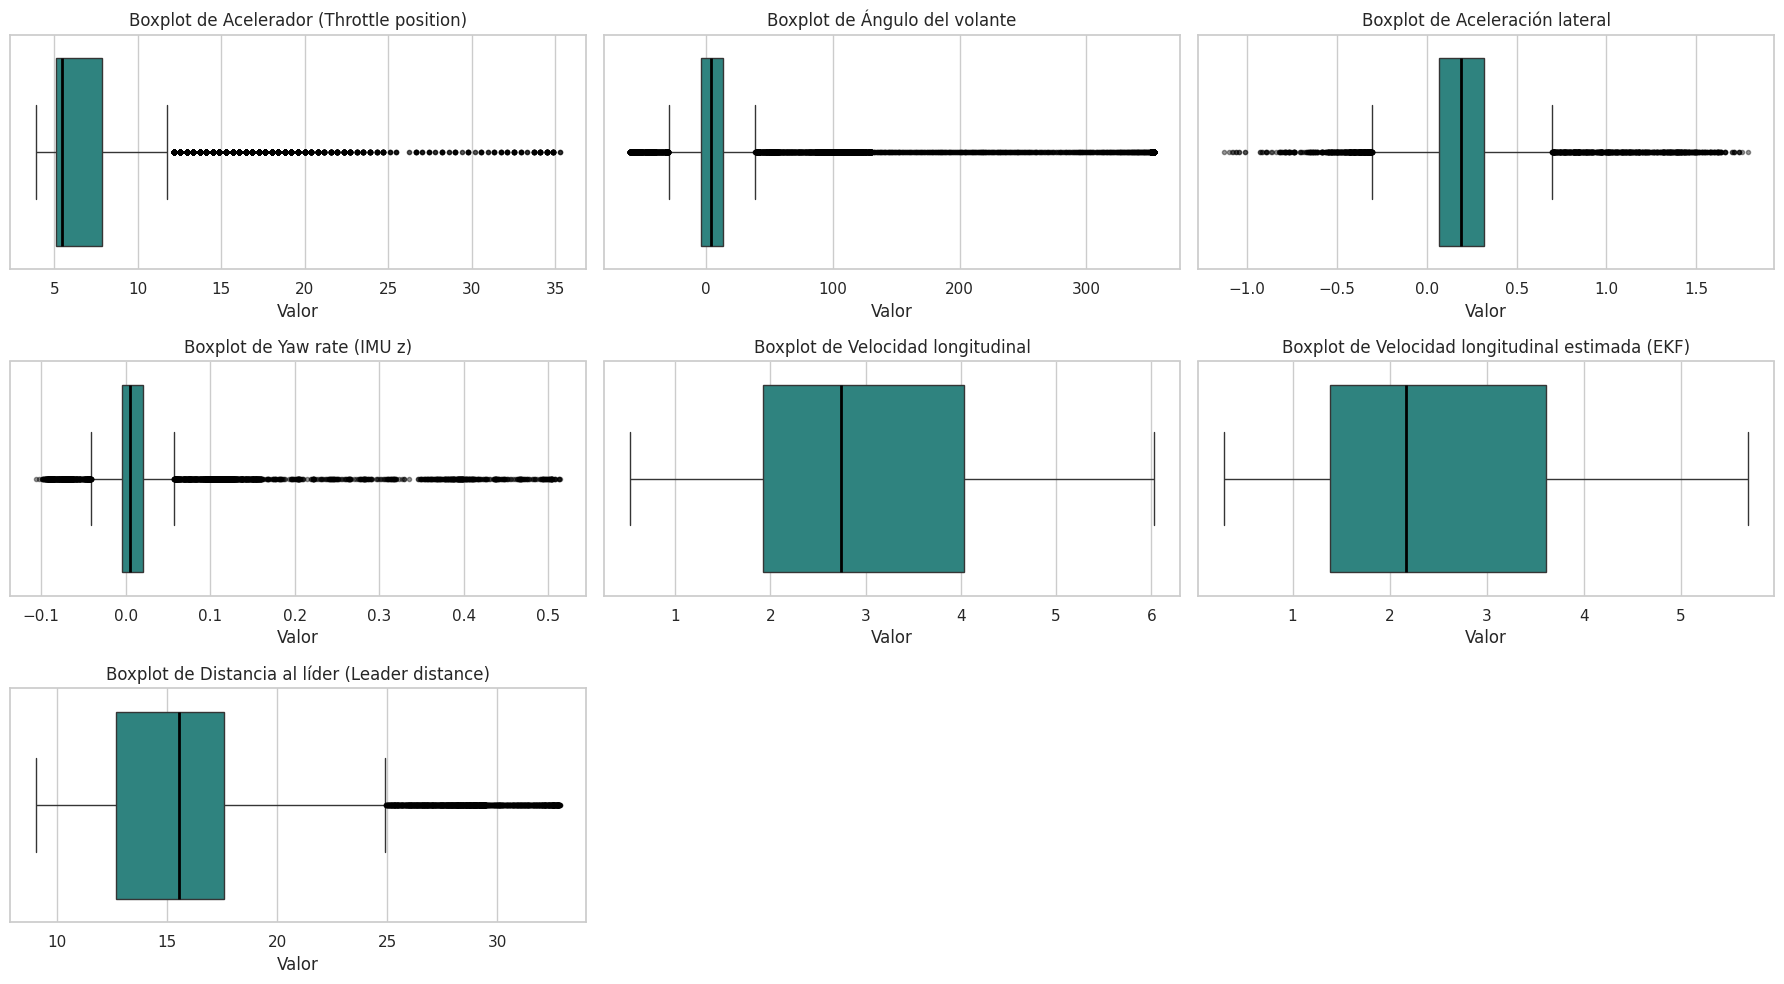

In [ ]:
#Boxplots con anotaciones

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Estilo general
sns.set_theme(style="whitegrid", palette="viridis")

#Señales a graficar
signals = [
    (fbk_by_topic["/vehicle_fbk.throttle_position"], "Acelerador (Throttle position)"),
    (fbk_by_topic["/vehicle_fbk.steering_wheel_angle"], "Ángulo del volante"),
    (latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"], "Aceleración lateral"),
    (imu_by_topic["/imu/data.angular_velocity.z"], "Yaw rate (IMU z)"),
    (velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"], "Velocidad longitudinal"),
    (ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"], "Velocidad longitudinal estimada (EKF)"),
    (leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"], "Distancia al líder (Leader distance)"),
]

#Configuración de la cuadrícula
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (df_sig, titulo) in enumerate(signals):

    #Elimina NaN e infinitos para evitar escalas aplastadas
    values = df_sig["value"].replace([np.inf, -np.inf], np.nan).dropna()

    sns.boxplot(
        x=values,
        ax=axes[i],
        orient="h",
        color=sns.color_palette("viridis", 1)[0],
        linewidth=1,
        fliersize=3,
        medianprops=dict(color="black", linewidth=2),
        whiskerprops=dict(linewidth=1),
        capprops=dict(linewidth=1),
        flierprops=dict(
            marker='o',
            markerfacecolor='black',
            markeredgecolor='black',
            alpha=0.4
        )
    )

    axes[i].set_title(f"Boxplot de {titulo}")
    axes[i].set_xlabel("Valor")
    axes[i].set_ylabel("")

#Oculta subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### **Resultados**

Los boxplots incluyen anotaciones de uartiles y una mediana resaltada para facilitar la interpretación y vincular la visualización con las estadísticas descriptivas. Dado que el recorrido corresponde a un tramo corto con una recta y una glorieta, los valores extremos observados se asocian principalmente a maniobras específicas y no a comportamientos anómalos.

* **vehicle_fbk | throttle_position:** La mayoría de los valores se concentran en rangos bajos, con algunos valores altos asociados a aceleraciones puntuales durante el recorrido.

* **vehicle_fbk | steering_wheel_angle:** Se observan valores cercanos a cero en tramos rectos y valores extremos asociados al giro en la glorieta.

* **vehicle_dyn_lat_acc | lateral_acceleration:**
La señal se concentra alrededor de cero, con valores extremos que corresponden a la maniobra de giro.

* **imu_data | angular_velocity.z (yaw rate):** Predominan valores cercanos a cero, con picos asociados al cambio de dirección en la glorieta y al ruido propio de la IMU.

* **vehicle_dynamics_radio_vel_long | longitudinal_velocity:** La velocidad longitudinal presenta una distribución estable, consistente con un recorrido corto y controlado.

* **ekf_temp | vehicle_state.vx (EKF):** La velocidad estimada muestra menor dispersión que la medición directa, reflejando el efecto de suavizado del filtro EKF.

* **leader_distance → distance (distancia al vehículo líder):**  
  La distribución se concentra en un rango medio de distancias, con valores atípicos hacia separaciones mayores. Para la visualización se excluyeron valores infinitos, los cuales representan periodos sin detección de un vehículo líder; esta exclusión se realizó únicamente con fines gráficos y no como un preprocesamiento definitivo.


## Distribución de los datos e identificación de sesgo

En esta sección se analizan las distribuciones de las señales seleccionadas mediante histogramas a fin de identificar posibles asimetrías, colas largas o sesgos que indiquen la necesidad de aplicar transformaciones no lineales en etapas posteriores del proyecto.



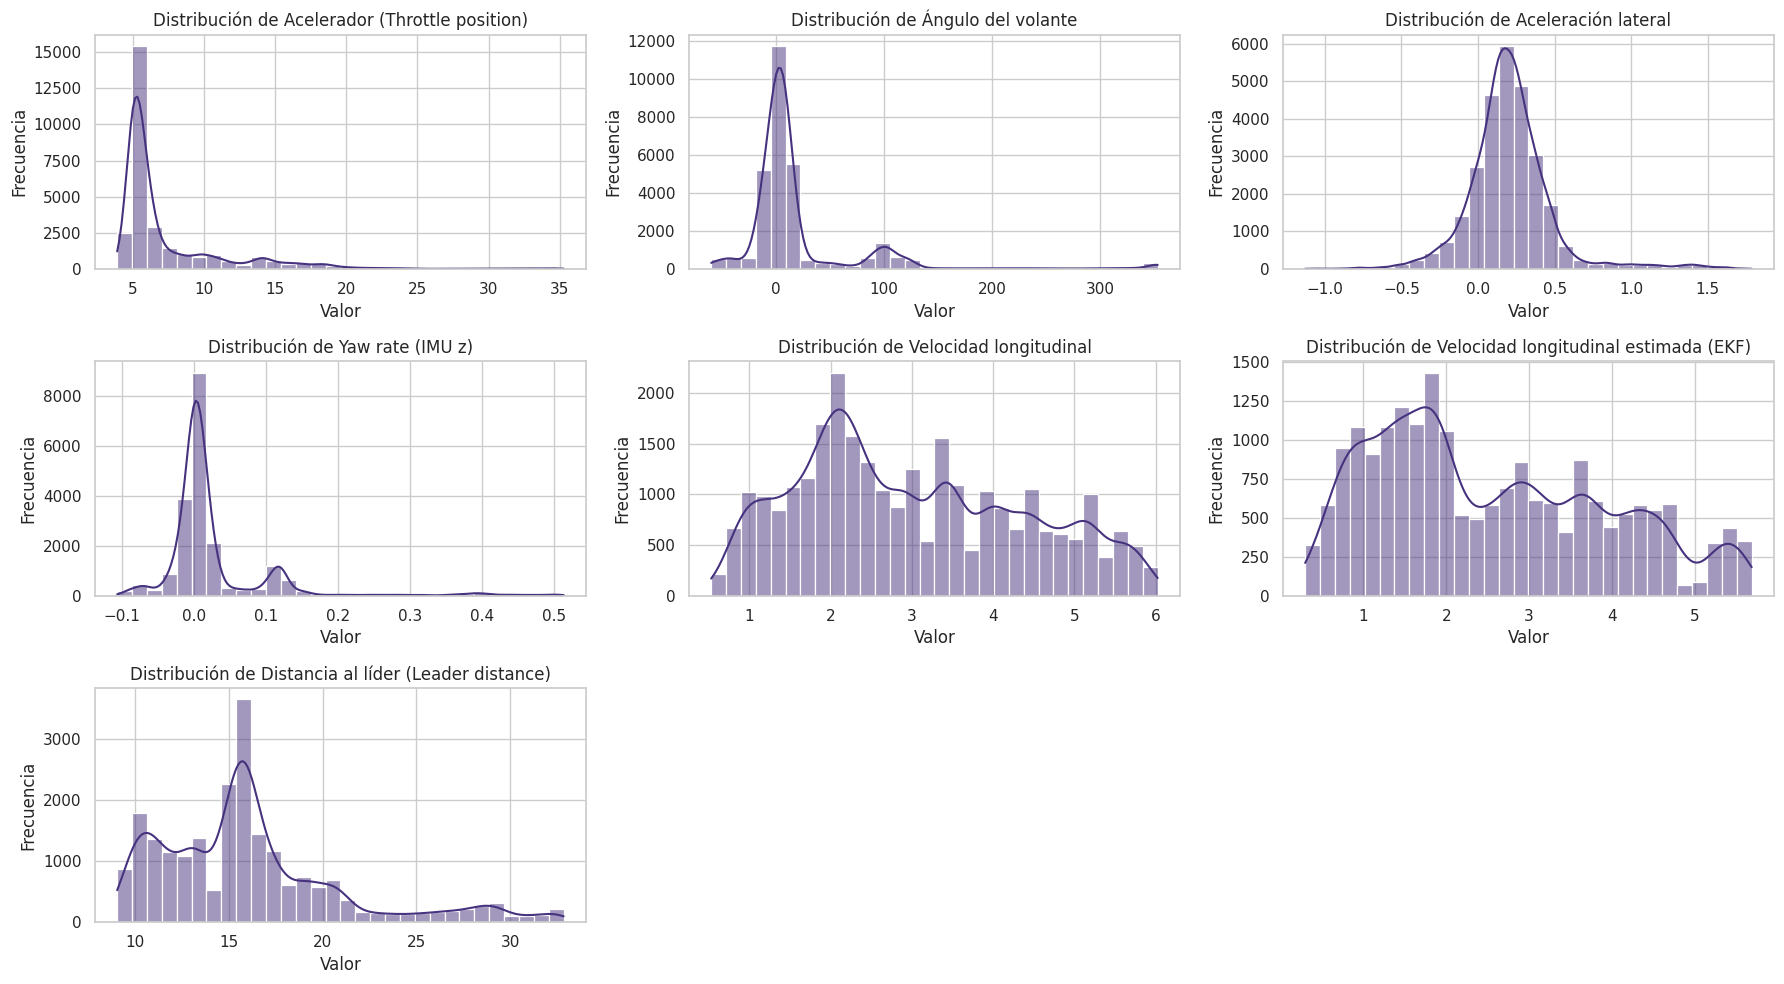

In [ ]:
#Grafica histogramas con KDE en una cuadrícula

sns.set_theme(style="whitegrid", palette="viridis")

#Lista de señales a graficar: (df, titulo)
signals = [
    (fbk_by_topic["/vehicle_fbk.throttle_position"], "Acelerador (Throttle position)"),
    (fbk_by_topic["/vehicle_fbk.steering_wheel_angle"], "Ángulo del volante"),
    (latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"], "Aceleración lateral"),
    (imu_by_topic["/imu/data.angular_velocity.z"], "Yaw rate (IMU z)"),
    (velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"], "Velocidad longitudinal"),
    (ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"], "Velocidad longitudinal estimada (EKF)"),
    (leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"], "Distancia al líder (Leader distance)"),
]

n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

for i, (df_sig, titulo) in enumerate(signals):

    #Elimina NaN e infinitos para que la distribución sea visible
    values = df_sig["value"].replace([np.inf, -np.inf], np.nan).dropna()

    sns.histplot(values, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribución de {titulo}")
    axes[i].set_xlabel("Valor")
    axes[i].set_ylabel("Frecuencia")

#Oculta subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### **Resultados**

Los histogramas permiten observar la forma de las distribuciones de las señales analizadas. Se identifican distribuciones asimétricas en variables de control como el acelerador y el ángulo del volante, mientras que las señales dinámicas y de estado estimado presentan distribuciones más suaves o multimodales. La distancia al vehículo líder muestra una distribución sesgada hacia valores mayores, asociada a distintos regímenes de seguimiento durante el recorrido; para su visualización se excluyeron valores infinitos correspondientes a periodos sin detección de líder. En conjunto, estas características reflejan el uso desigual de ciertos rangos de operación y no evidencian la necesidad de aplicar transformaciones no lineales en esta etapa del análisis.


## Análisis temporal por señal

En esta sección se identifican tendencias temporales y se verifica la estabilidad, cambios puntuales (recta vs glorieta), y coherencia con el escenario del recorrido.

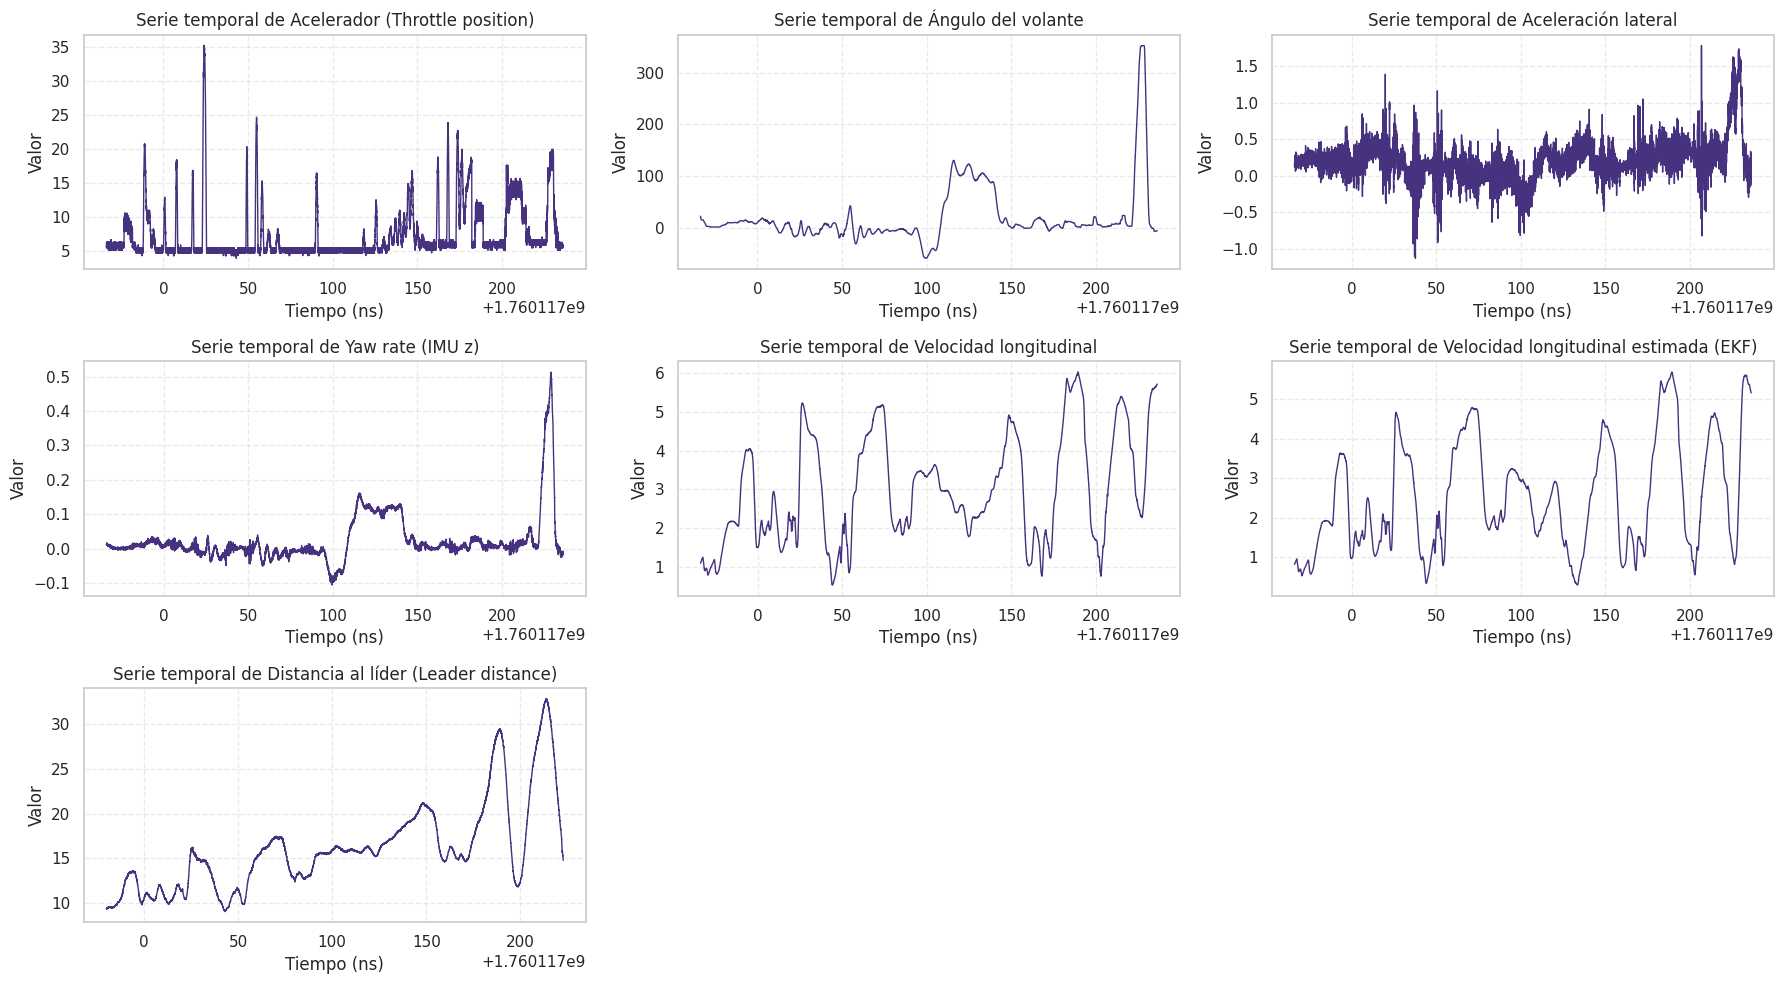

In [ ]:
#Series temporales de señales en función del tiempo

#Estilo general
sns.set_theme(style="whitegrid", palette="viridis")

#Señales a graficar: (df, titulo)
signals = [
    (fbk_by_topic["/vehicle_fbk.throttle_position"], "Acelerador (Throttle position)"),
    (fbk_by_topic["/vehicle_fbk.steering_wheel_angle"], "Ángulo del volante"),
    (latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"], "Aceleración lateral"),
    (imu_by_topic["/imu/data.angular_velocity.z"], "Yaw rate (IMU z)"),
    (velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"], "Velocidad longitudinal"),
    (ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"], "Velocidad longitudinal estimada (EKF)"),
    (leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"], "Distancia al líder (Leader distance)"),
]

#Configuración de la cuadrícula
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (df_sig, titulo) in enumerate(signals):

    #Copia mínima para filtrar solo para graficar
    df_plot = df_sig[["timestamp", "value"]].copy()
    df_plot["value"] = df_plot["value"].replace([np.inf, -np.inf], np.nan)
    df_plot = df_plot.dropna()

    sns.lineplot(
        data=df_plot,
        x="timestamp",
        y="value",
        ax=axes[i],
        linewidth=1
    )

    axes[i].set_title(f"Serie temporal de {titulo}")
    axes[i].set_xlabel("Tiempo (ns)")
    axes[i].set_ylabel("Valor")
    axes[i].grid(True, linestyle="--", alpha=0.4)

#Oculta subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### **Resultados**

Las series temporales reflejan un recorrido corto compuesto por tramos rectos y una glorieta, sin comportamientos anómalos evidentes.

* **vehicle_fbk | throttle_position:** Se observan incrementos puntuales de aceleración separados por periodos de baja actividad, consistentes con arranques, ajustes de velocidad y desaceleraciones.

* **vehicle_fbk | steering_wheel_angle:** La señal permanece cercana a cero en tramos rectos y presenta cambios pronunciados durante la glorieta, reflejando maniobras de giro.

* **vehicle_dyn_lat_acc | lateral_acceleration:** La aceleración lateral se mantiene cercana a cero la mayor parte del tiempo, con picos positivos y negativos asociados al giro en la glorieta.

* **imu_data | angular_velocity.z (yaw rate):** El yaw rate muestra valores bajos en rectas y un aumento sostenido durante el giro, además de pequeñas oscilaciones atribuibles al ruido de la IMU.

* **vehicle_dynamics_radio_vel_long | longitudinal_velocity:** La velocidad longitudinal presenta variaciones graduales, con incrementos y reducciones coherentes con aceleraciones y desaceleraciones controladas.

* **ekf_temp | vehicle_state.vx (EKF):** La velocidad estimada sigue el mismo patrón general que la medición directa, pero con una señal más suave y menor variabilidad.

* **leader_distance | leader_distance.distance:** La distancia al vehículo líder varía principalmente entre ~10–20 m, con incrementos marcados hacia el final del recorrido que indican mayor separación o pérdida parcial de seguimiento. Para graficar se excluyeron valores infinitos, los cuales corresponden a periodos sin detección de líder.


# VII. Análisis multivariante


## Análisis de correlación

En esta sección se evalúan relaciones lineales entre las variables continuas más relevantes del sistema para identificar dependencias físicas esperadas y posibles redundancias.

### Eliminación de NaN e inf

Primero, integramos variables continuas de distintos sensores y eliminamos inf y NaN. No normalizamos (correcto para correlación de Pearson).

In [ ]:
#Selecciona y renombra señales clave
df_corr = pd.DataFrame({
    "throttle": fbk_by_topic["/vehicle_fbk.throttle_position"]["value"],
    "steering_angle": fbk_by_topic["/vehicle_fbk.steering_wheel_angle"]["value"],
    "lateral_acc": latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"]["value"],
    "yaw_rate": imu_by_topic["/imu/data.angular_velocity.z"]["value"],
    "vel_long": velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"]["value"],
    "vel_ekf": ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"]["value"],
    "leader_distance": leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"]["value"]
})

#Elimina valores infinitos y faltantes para correlación
df_corr = df_corr.replace([np.inf, -np.inf], np.nan).dropna()

#Verifica tamaño final del dataset
print("Tamaño del dataset para correlación:", df_corr.shape)

Tamaño del dataset para correlación: (0, 7)


### Agrupación por ventanas de tiempo
Debido a que las señales provienen de sensores con distintas frecuencias de muestreo, se realizó una alineación temporal simple mediante agrupación por ventanas de tiempo, permitiendo un análisis de correlación consistente entre variables.

In [ ]:
#Alineación temporal simple para análisis de correlación

def preparar_signal(df, nombre):
    df_tmp = df[["timestamp", "value"]].copy()
    df_tmp["timestamp"] = (df_tmp["timestamp"] / 1e8).round(0)  # ~100 ms
    df_tmp = df_tmp.groupby("timestamp").mean()
    df_tmp.columns = [nombre]
    return df_tmp

#Prepara cada señal
sig_throttle = preparar_signal(
    fbk_by_topic["/vehicle_fbk.throttle_position"], "throttle"
)

sig_steer = preparar_signal(
    fbk_by_topic["/vehicle_fbk.steering_wheel_angle"], "steering_angle"
)

sig_latacc = preparar_signal(
    latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"], "lateral_acc"
)

sig_yaw = preparar_signal(
    imu_by_topic["/imu/data.angular_velocity.z"], "yaw_rate"
)

sig_vel = preparar_signal(
    velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"], "vel_long"
)

sig_ekf = preparar_signal(
    ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"], "vel_ekf"
)

sig_leader = preparar_signal(
    leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"], "leader_distance"
)

#Une todas las señales por timestamp
df_corr = (
    sig_throttle
    .join(sig_steer, how="inner")
    .join(sig_latacc, how="inner")
    .join(sig_yaw, how="inner")
    .join(sig_vel, how="inner")
    .join(sig_ekf, how="inner")
    .join(sig_leader, how="inner")
)

#Elimina valores infinitos y faltantes
df_corr = df_corr.replace([np.inf, -np.inf], np.nan).dropna()

print("Tamaño del dataset para correlación:", df_corr.shape)
display(df_corr.head())


Tamaño del dataset para correlación: (0, 7)


,throttle,steering_angle,lateral_acc,yaw_rate,vel_long,vel_ekf,leader_distance
timestamp,,,,,,,


### Resultados

Incluso después de binnig, no existe ningún timestamp común a TODAS las señales al mismo tiempo, ni siquiera después de redondear. Es decir, muchas señales no coinciden temporalmente todas juntas debido a diferentes frecuencias de muestreo (algunas empiezan antes, otras después, otras tienen huecos grandes). Por lo anterior, una sola matriz de correlaciones no funcionaría. Por ello se realizó un alineamiento temporal aproximado por proximidad para evaluar correlaciones bivariadas entre variables relevantes.


## Correlación Velocidad longitudinal medida vs EKF

In [ ]:
#Correlación bivariada: velocidad medida vs velocidad estimada (EKF)

df_vel = velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"][["timestamp", "value"]].copy()
df_vel.columns = ["timestamp", "vel_long"]

df_ekf = ekftemp_by_topic["/estimation/ekf/vehicle_state.vx"][["timestamp", "value"]].copy()
df_ekf.columns = ["timestamp", "vel_ekf"]

#Ordena por tiempo
df_vel = df_vel.sort_values("timestamp")
df_ekf = df_ekf.sort_values("timestamp")

#Alineación temporal aproximada
df_merge = pd.merge_asof(
    df_vel,
    df_ekf,
    on="timestamp",
    direction="nearest",
    tolerance=1e8  # ~100 ms
)

df_merge = df_merge.dropna()

print("Tamaño del dataset alineado:", df_merge.shape)
display(df_merge.head())

print("Correlación Pearson:", df_merge["vel_long"].corr(df_merge["vel_ekf"]))


Tamaño del dataset alineado: (27755, 3)


,timestamp,vel_long,vel_ekf
0,1.760117e+09,1.090861,0.816080
1,1.760117e+09,1.091252,0.816080
2,1.760117e+09,1.092033,0.816754
3,1.760117e+09,1.092641,0.818059
4,1.760117e+09,1.094043,0.818059


Correlación Pearson: 0.9564308927528272


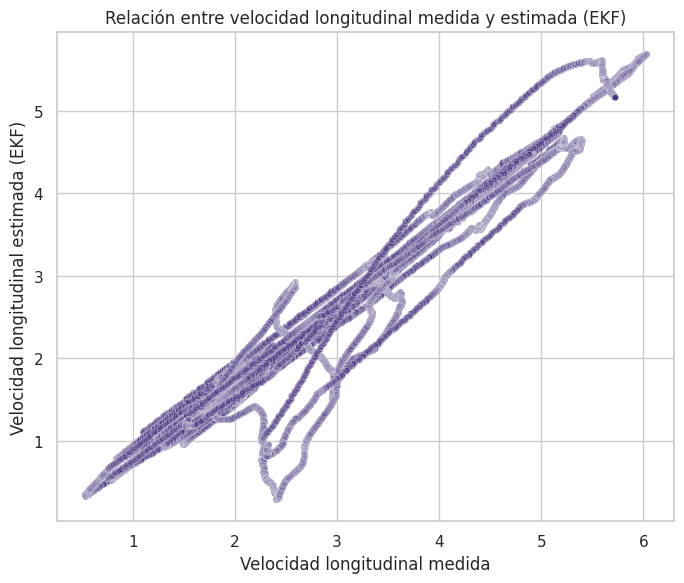

In [ ]:
#Scatter plot: velocidad longitudinal medida vs velocidad estimada (EKF)

sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df_merge,
    x="vel_long",
    y="vel_ekf",
    alpha=0.4,
    s=20
)

plt.title("Relación entre velocidad longitudinal medida y estimada (EKF)")
plt.xlabel("Velocidad longitudinal medida")
plt.ylabel("Velocidad longitudinal estimada (EKF)")

plt.tight_layout()
plt.show()


### Resultado

La correlación entre la velocidad longitudinal medida y la velocidad longitudinal estimada mediante EKF es alta (coeficiente de Pearson = 0.96), lo que indica una fuerte relación lineal positiva entre ambas señales. Este resultado confirma la coherencia entre la medición directa y la estimación obtenida por fusión sensorial, así como el efecto de suavizado del EKF, observado previamente en el análisis univariado.

La dispersión observada alrededor de la diagonal se debe al efecto de suavizado y retardo introducido por el filtro EKF, así como a la naturaleza temporal de las señales, lo cual genera trayectorias no independientes en el espacio de velocidades.


## Correlación control del acelerador vs velocidad longitudinal medida

Tamaño del dataset alineado: (29149, 3)


,timestamp,throttle,vel_long
0,1.760117e+09,6.272,1.117404
1,1.760117e+09,5.488,1.120507
2,1.760117e+09,5.488,1.123310
3,1.760117e+09,5.880,1.123310
4,1.760117e+09,5.880,1.125967


Correlación Pearson (throttle vs vel_long): 0.0036


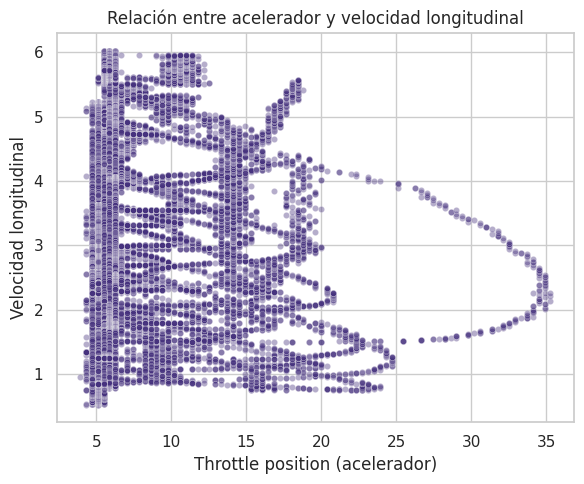

In [ ]:
# Correlación: throttle_position vs vel_long

# Selección de señales
df_throttle = fbk_by_topic["/vehicle_fbk.throttle_position"][["timestamp", "value"]].rename(
    columns={"value": "throttle"}
)

df_vel = velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"][["timestamp", "value"]].rename(
    columns={"value": "vel_long"}
)

# Alineación temporal (merge por timestamp más cercano)
df_corr = pd.merge_asof(
    df_throttle.sort_values("timestamp"),
    df_vel.sort_values("timestamp"),
    on="timestamp",
    direction="nearest"
).dropna()

print("Tamaño del dataset alineado:", df_corr.shape)
display(df_corr.head())

# Correlación de Pearson
corr_throttle_vel = df_corr["throttle"].corr(df_corr["vel_long"])
print(f"Correlación Pearson (throttle vs vel_long): {corr_throttle_vel:.4f}")

# ============================================
# Scatter plot
# ============================================

sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_corr,
    x="throttle",
    y="vel_long",
    alpha=0.4,
    s=20
)

plt.title("Relación entre acelerador y velocidad longitudinal")
plt.xlabel("Throttle position (acelerador)")
plt.ylabel("Velocidad longitudinal")
plt.tight_layout()
plt.show()


### Resultados

La correlación entre la posición del acelerador y la velocidad longitudinal es prácticamente nula (coeficiente de Pearson = 0.0036), lo que indica que no existe una relación lineal directa instantánea entre ambas señales.

El diagrama de dispersión muestra una nube amplia y estructurada, donde un mismo valor de acelerador se asocia a múltiples rangos de velocidad. Este comportamiento es esperable ya que la velocidad longitudinal depende no solo del acelerador, sino también de factores dinámicos y de control como frenado, pendientes, inercia del vehículo y estrategias del controlador longitudinal. Además, el efecto temporal (retardos y acumulación de aceleración) rompe la relación punto a punto entre ambas variables.

Este resultado confirma que el acelerador actúa como variable de control, mientras que la velocidad es una respuesta dinámica, por lo que su relación no es lineal ni instantánea.

## Correlación IMU vs aceleración lateral

Tamaño del dataset alineado: (19921, 7)


,elapsed time_yaw,timestamp,topic_yaw,yaw_rate,elapsed time_lat,topic_lat,lateral_acc
0,0.036272,1.760117e+09,/imu/data.angular_velocity.z,0.012288,0.048878,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.171359
1,0.048860,1.760117e+09,/imu/data.angular_velocity.z,0.011920,0.048878,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.171359
2,0.061830,1.760117e+09,/imu/data.angular_velocity.z,0.010593,0.061621,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.171359
3,0.071309,1.760117e+09,/imu/data.angular_velocity.z,0.009341,0.070091,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.165751
4,0.090066,1.760117e+09,/imu/data.angular_velocity.z,0.010406,0.091687,/ces_ars430di/vehicle_dynamics.lateral_acceler...,0.138953


Correlación Pearson (yaw_rate vs lateral_acc): 0.6869


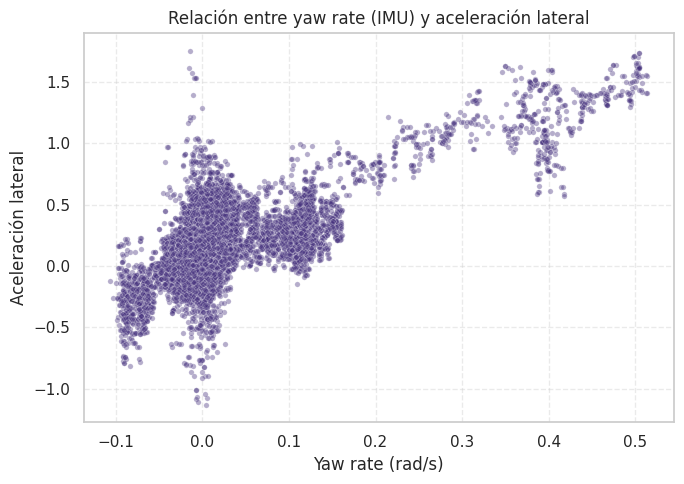

In [ ]:
# Correlación yaw_rate (IMU) vs aceleración lateral

# Alineación temporal
df_yaw_lat = pd.merge_asof(
    imu_by_topic["/imu/data.angular_velocity.z"].sort_values("timestamp"),
    latacc_by_topic["/ces_ars430di/vehicle_dynamics.lateral_acceleration"].sort_values("timestamp"),
    on="timestamp",
    direction="nearest",
    suffixes=("_yaw", "_lat")
)

df_yaw_lat = df_yaw_lat.rename(columns={
    "value_yaw": "yaw_rate",
    "value_lat": "lateral_acc"
})

print("Tamaño del dataset alineado:", df_yaw_lat.shape)
display(df_yaw_lat.head())

# Correlación de Pearson
corr_yaw_lat = df_yaw_lat["yaw_rate"].corr(df_yaw_lat["lateral_acc"])
print(f"Correlación Pearson (yaw_rate vs lateral_acc): {corr_yaw_lat:.4f}")

# Scatter plot
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=df_yaw_lat["yaw_rate"],
    y=df_yaw_lat["lateral_acc"],
    alpha=0.4,
    s=15
)

plt.title("Relación entre yaw rate (IMU) y aceleración lateral")
plt.xlabel("Yaw rate (rad/s)")
plt.ylabel("Aceleración lateral")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Resultados
La correlación entre el yaw rate medido por la IMU y la aceleración lateral es moderada–alta (coeficiente de Pearson = 0.69), lo cual es consistente con la dinámica vehicular esperada durante maniobras de giro como la glorieta. El diagrama de dispersión muestra una relación positiva clara: a mayor tasa de giro, mayor aceleración lateral, especialmente en el régimen de curvas pronunciadas.

La dispersión observada alrededor de la tendencia principal se explica por efectos de ruido del sensor IMU, variaciones en la velocidad del vehículo y la naturaleza no lineal de la dinámica lateral en maniobras complejas (como la glorieta). Aun así, la relación confirma la coherencia física entre ambas señales y valida su uso conjunto para análisis dinámico y modelado del comportamiento del vehículo.

## Correlación distancia al líder vs velocidad longitudinal

Tamaño del dataset alineado: (24435, 7)


,elapsed time_x,timestamp,topic_x,leader_distance,elapsed time_y,topic_y,vel_long
0,13.931237,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.352364,13.930285,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.666421
1,13.936586,1.760117e+09,/planning/leader_following/leader_distance.dis...,inf,13.939412,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.667336
2,13.938404,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.338982,13.939412,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.667336
3,13.947964,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.351946,13.948684,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.668411
4,13.957742,1.760117e+09,/planning/leader_following/leader_distance.dis...,9.356758,13.957727,/ces_ars430di/vehicle_dynamics.longitudinal_ve...,1.670241


Correlación Pearson (leader_distance vs vel_long): nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


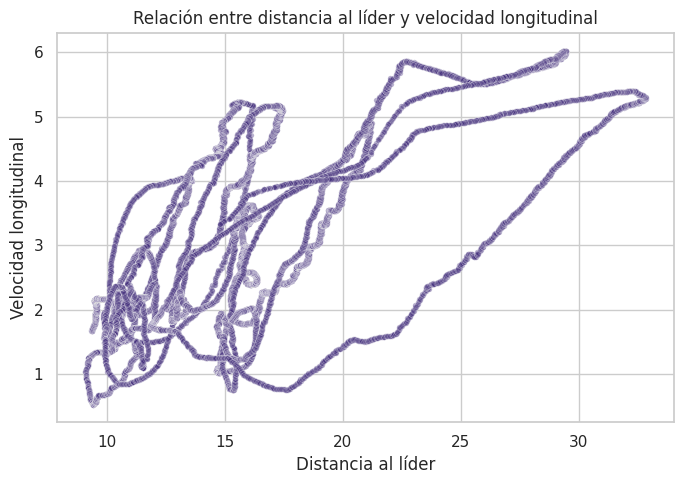

In [ ]:
# Alinear señales por timestamp
df_leader_vel = pd.merge_asof(
    leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"]
        .sort_values("timestamp"),
    velong_by_topic["/ces_ars430di/vehicle_dynamics.longitudinal_velocity"]
        .sort_values("timestamp"),
    on="timestamp",
    direction="nearest",
    tolerance=1e7  # tolerancia en ns (ajusta si es necesario)
)

# Renombrar columnas para claridad
df_leader_vel = df_leader_vel.rename(columns={
    "value_x": "leader_distance",
    "value_y": "vel_long"
})

print("Tamaño del dataset alineado:", df_leader_vel.shape)
display(df_leader_vel.head())

# Correlación de Pearson
corr_ld_v = df_leader_vel["leader_distance"].corr(df_leader_vel["vel_long"])
print(f"Correlación Pearson (leader_distance vs vel_long): {corr_ld_v:.4f}")

# Scatter plot
sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_leader_vel,
    x="leader_distance",
    y="vel_long",
    alpha=0.4,
    s=15
)

plt.title("Relación entre distancia al líder y velocidad longitudinal")
plt.xlabel("Distancia al líder")
plt.ylabel("Velocidad longitudinal")
plt.tight_layout()
plt.show()


### Resultados

La correlación entre la distancia al líder y la velocidad longitudinal no pudo ser cuantificada mediante el coeficiente de Pearson, ya que la señal de distancia contiene valores infinitos (inf), lo que invalida el cálculo estadístico y genera un coeficiente NaN. Estos valores corresponden a instantes en los que no se detecta un vehículo líder, lo cual es consistente con el escenario de conducción observado.

A pesar de ello, el diagrama de dispersión permite identificar una relación no lineal y dependiente del contexto: a mayores distancias al líder se asocian velocidades longitudinales más altas, mientras que a distancias cortas la velocidad se mantiene limitada. La estructura en trayectorias observada en el plano distancia–velocidad refleja la naturaleza temporal del seguimiento vehicular y el comportamiento del controlador longitudinal, más que una relación lineal directa entre ambas variables.

## Correlación acelerador vs distancia al líder

Tamaño del dataset alineado: (22061, 3)
Correlación Pearson (leader_distance vs throttle): 0.26580966860012645


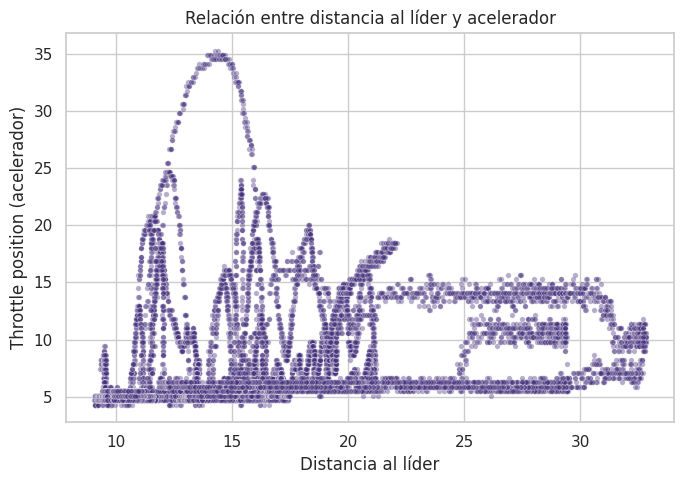

In [ ]:
# Alinear leader_distance con throttle_position por timestamp
df_leader_throttle = pd.merge_asof(
    leaderdistance_by_topic["/planning/leader_following/leader_distance.distance"]
        .sort_values("timestamp")[["timestamp", "value"]]
        .rename(columns={"value": "leader_distance"}),
    fbk_by_topic["/vehicle_fbk.throttle_position"]
        .sort_values("timestamp")[["timestamp", "value"]]
        .rename(columns={"value": "throttle"}),
    on="timestamp",
    direction="nearest"
)

# Eliminar valores infinitos o faltantes
df_leader_throttle = df_leader_throttle.replace([np.inf, -np.inf], np.nan).dropna()

print("Tamaño del dataset alineado:", df_leader_throttle.shape)

# Correlación de Pearson
corr_leader_throttle = df_leader_throttle["leader_distance"].corr(
    df_leader_throttle["throttle"]
)

print("Correlación Pearson (leader_distance vs throttle):", corr_leader_throttle)

#Gráfica de scatter plot

sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_leader_throttle,
    x="leader_distance",
    y="throttle",
    alpha=0.4,
    s=15
)

plt.title("Relación entre distancia al líder y acelerador")
plt.xlabel("Distancia al líder")
plt.ylabel("Throttle position (acelerador)")
plt.tight_layout()
plt.show()


### Resultados
La correlación entre la distancia al líder y la posición del acelerador es positiva pero moderada (coeficiente de Pearson = 0.27). Esto indica que, en general, a mayores distancias respecto al vehículo líder se tiende a aplicar una mayor aceleración, aunque la relación no es estrictamente lineal.

La dispersión observada en el diagrama refleja la naturaleza del control longitudinal, donde el acelerador actúa de forma discreta y dependiente del contexto, incorporando zonas de saturación, retardos y regímenes de control (por ejemplo, mantenimiento de velocidad o seguimiento estable). Por ello, esta variable no responde de manera directa y continua a la distancia al líder, lo cual es consistente con un sistema de conducción autónoma basado en reglas o control jerárquico.

# VIII. Conclusiones

En este trabajo se realizó un análisis exploratorio de un conjunto de datos multisensoriales provenientes del coche autónomo y guiado por el Fantástico, registrados en formato MCAP. A partir de la visualización y caracterización de datos de cámaras RGB, LiDAR, radar, IMU, GNSS, bus CAN y módulos de percepción, planeación y control, se logró comprender tanto la estructura como el comportamiento dinámico del sistema durante una operación real.

El análisis permitió verificar la alta calidad y redundancia de los datos, aspecto fundamental en sistemas de conducción autónoma donde la seguridad y la calidad son críticas. Las señales inerciales mostraron coherencia física, con aceleraciones y velocidades angulares acordes a las maniobras observadas. La representación en cuaterniones evidenció cambios suaves de orientación, lo que confirma una conducción estable. Asimismo, la correlación entre distintas fuentes de medición validó la consistencia interna del sistema de estimación de estado basado en fusión sensorial.

La visualización integrada en Foxglove facilitó la interpretación del entorno percibido por el vehículo, permitiendo analizar simultáneamente el contexto visual, la geometría tridimensional del entorno, la trayectoria recorrida y el estado dinámico del automóvil.

Adicionalmente, el análisis univariado y multivariado permitió identificar distribuciones asimétricas, valores atípicos y relaciones entre variables clave del sistema. Las señales de control mostraron comportamientos no lineales y dependientes del contexto, mientras que las variables dinámicas presentaron patrones consistentes con la operación del vehículo en los datos del traeycto proporcionado. El análisis temporal confirmó la coherencia del recorrido, y los estudios de correlación dieron respaldo a relaciones físicas relevantes, como la alta concordancia entre velocidades medidas y estimadas, así como la interacción entre dinámica lateral y yaw rate.

En conjunto, este análisis exploratorio sienta las bases para las siguientes fases del proyecto. Proporciona un entendimiento de los datos, identifica limitaciones menores y confirma que la información disponible es suficiente y confiable para el ajuste fino sobre algoritmos de comportamiento con capacidad de razonamiento.

En conclusión, estos resultados respaldan la viabilidad de utilizar este conjunto de datos en simulación, entrenamiento y evaluación de modelos avanzados de conducción autónomo. Seguiremos trabajando en el dataset de calidad que podrá ser usado tanto para entrenamiento y pruebas.
